In [1]:
import warnings
from collections import OrderedDict
import pandas as pd

import scipy
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.utils import resample
import pysindy as ps
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from scipy.integrate import odeint
from scipy.stats import multivariate_normal
import seaborn as sns



from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

from sklearn.metrics import mean_squared_error
# mean_squared_error(obs_height, pred_param_height[k2], squared = False)

In [2]:
## Upsampling Function
def resample_data(data, scale = int(200/35)):
    """Code function to either upsample or downsample a dataset depending on the factor"""
    
    def upsample(original_data, factor = 2):
        # Upsampling factor
        upsampling_factor = factor

        # Calculate new number of samples
        new_num_samples = len(original_data) * upsampling_factor

        # Generate new indices for the upsampled data
        new_indices = np.linspace(0, len(original_data) - 1, new_num_samples)

        # Upsample the data
        upsampled_data = np.interp(new_indices, np.arange(len(original_data)), original_data)
        return upsampled_data
    
    
    sz = data.shape
    
    if len(sz) < 2:
        upsampled_data = upsample(data.reshape(-1),scale)
        return upsampled_data
        
    else:
        Data = []
        for i in range(sz[-1]):
            data_i = data[:,i].reshape(-1)
            upsampled_i = upsample(data_i, scale)
            Data.append(upsampled_i)
        Data = np.asarray(Data).T
        return Data

def SINDY(noisy_data, t, threshold = 0.03, wl = 15, condit = False):
    """Fits SINDy model to a data and returns the resulting coefficients"""
    Poly_lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=True)
    optimizer = ps.STLSQ(threshold)#threshold = 0.3)
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(noisy_data,t)
    L_dl = np.vstack((noisy_data,dldt)).T

    model = ps.SINDy(
        differentiation_method=smoothed_fd,
        feature_library=Poly_lib,
        optimizer=optimizer,
        feature_names=["L", "dL"] 
    )
    if condit: 
        model.fit(L_dl, t)
        model.print()
        model.get_feature_names()
        return model.coefficients()#.reshape(-1)
    
    else:
        model.fit(L_dl, t)
        return L_dl, model
        

def sort_matrix(matrix, col_idx = -1):
    """Sorts the element of a matrix by a predifine column in ascending order"""
    if len(matrix.shape)  == 1:
        matrix= matrix.reshape(-1,1)
    # Sort the matrix by the specified column
    sorted_matrix = sorted(matrix, key=lambda x: x[col_idx])
    return np.array(sorted_matrix)


def split_matrix(matrix):
    """Splits the last column of a matrix from the original matrix and returns the new matrix and the column"""
    matrix = matrix.tolist()
    # Split the last column from the matrix
    last_column = [row.pop() for row in matrix]
    return np.array(matrix),np.array(last_column)

def min_idx(arr1,arr2):
    """Finds the minimum of arr2 and return the corresponding arr1 values with it """
#     arr2 = arr2.tolist()
    min_value = min(arr2)
    min_index = arr2.index(min_value)
    return ([arr1[min_index],min_value])

def differentiate(data, time, wl=15):
    """Function to carry out numerical differentiation with respect to time using smoothed finite difference"""
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(data,time)
    d2ldt = smoothed_fd(dldt, time)
    d3ldt = smoothed_fd(d2ldt, time)
    return dldt,d2ldt,d3ldt

# Code to generate publication worthy images 
def plt_figures(rows=1, cols=1, fontsize=20, figsize=(10, 6), dpi=600):
    import matplotlib as mpl

    # Setting global parameters
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.titlesize'] = fontsize  # Setting title font size same as other fonts
    mpl.rcParams['legend.fontsize'] = fontsize
    
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'  # 'Times New Roman'

    fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=dpi)
    
    return ax

In [3]:
class My_STLSQ:
    def __init__(self, threshold=0.05, fit_intcpt = True):
        self.threshold = threshold
        self.fit_intcpt = fit_intcpt  
                

    def fit(self, True_X, y):
        """
        Perform least squares regression with LASSO regularization
        Parameters:
        -----------
        True_X : numpy array
            Feature matrix of shape (n_samples, n_features)
        y : numpy array
            Response vector of shape (n_samples,)
        self.threshold : float
            LASSO regularization parameter

        Returns:
        --------
        coef : numpy array
            Coefficient vector of the final model
        """

        if self.fit_intcpt:
            # Add a bias term to the input data
            X_ = np.insert(True_X, 0, 1, axis=1)
        else: X_ = np.copy(True_X)

        if len(y.shape) == 1:
            y = y.reshape(-1,1)
            
        n_features = X_.shape[1]
        self.Coeffs = []
        for i in range(y.shape[-1]):
            X = np.copy(X_)
            y_i = y[:,i] 
            model = LinearRegression()
            coef = np.zeros(n_features)
            while True:
                model.fit(X, y_i)
                coef_new = model.coef_
                if np.max(np.abs(coef_new - coef)) < 1e-5:
                    break
                coef = coef_new
                small_coef = np.abs(coef) < self.threshold
                if np.sum(small_coef) == 0:
                    break
                X = X[:, ~small_coef]
                coef = coef[~small_coef]
            indx = find_indexes(X_[0],X[0])
            coefficient = np.zeros(n_features)
            coefficient[indx] = coef
            self.Coeffs.append(coefficient)
        return np.array(self.Coeffs)

    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Coeffs)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

    
    
class SequentialThresholdLeastSquares:
    """Sequential threshold based on correlation"""
    def __init__(self, threshold=0.05, fit_intcpt = False):
        self.threshold = threshold*10
        self.fit_intcpt = fit_intcpt  
                
    
    def fit(self, X, y, ):        
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1) 
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
        
        self.Beta = [] #np.zeroes(y.shape[-1],X.shape[-1])
        for t in range(y.shape[-1]):
            yt = y[:,t]
            # Initialize the parameter vector
            self.beta = np.zeros(X.shape[1])

            # Compute the initial residual and RSS
            r = yt - np.dot(X, self.beta)
            RSS = np.sum(r**2)

            # Iterate until convergence
            while True:
                # Compute the correlation coefficients
                corr = np.abs(np.dot(X.T, r))

                # Find the feature with the highest correlation
                j_star = np.argmax(corr)

                # Check if the highest correlation is above the threshold
                if corr[j_star] > self.threshold:
                    # Compute the new parameter estimate for feature j_star
                    beta_j_star = np.dot(X[:,j_star], r) / np.dot(X[:,j_star], X[:,j_star])

                    # Update the parameter vector and residual
                    self.beta[j_star] += beta_j_star
                    r -= beta_j_star * X[:,j_star]
                    RSS = np.sum(r**2)
                else:
                    break
            self.Beta.append(self.beta)
        return np.array(self.Beta)
    
    def predict(self, X):
        if self.fit_intcpt:
            # Add a bias term to the input data
            X = np.insert(X, 0, 1, axis=1)
        beta = np.array(self.Beta)
        
        if len(beta.shape) == 1:
            beta = beta.reshape(-1,1)
            
        Y_pred = np.dot(X,beta.T)
        return np.array(Y_pred)

def LR(X, y, alpha, n_features):
    model = LinearRegression()
    coef = np.zeros(n_features)
    while True:
        model.fit(X, y)
        coef_new = model.coef_
        if np.max(np.abs(coef_new - coef)) < 1e-5:
            break
        coef = coef_new
        small_coef = np.abs(coef) < self.threshold
        if np.sum(small_coef) == 0:
            break
        X = X[:, ~small_coef]
        coef = coef[~small_coef]
    return X,coef


def find_indexes(array, elements):
    if type(array) != list:
        array = array.tolist()
        
    elements = np.array(elements)
    indexes = []
    for element in elements:
        try:
            index = array.index(element)
            indexes.append(index)
        except ValueError:
            indexes.append(None)
    return indexes

def plot_multivariate_normal(data, xlabel='x', ylabel='y', title='Multivariate Normal Distribution'):
    # Compute the mean and covariance of the data
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)

    # Create a grid of points for the x and y axes
    x, y = np.mgrid[mean[0]-3*np.sqrt(cov[0,0]):mean[0]+3*np.sqrt(cov[0,0]):100j,
                    mean[1]-3*np.sqrt(cov[1,1]):mean[1]+3*np.sqrt(cov[1,1]):100j]

    # Create a multivariate normal distribution using the mean and covariance
    mvn = multivariate_normal(mean=mean, cov=cov)

    # Evaluate the PDF of the multivariate normal distribution at each point on the grid
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    pdf = mvn.pdf(pos)
    
    # Set the plot title and axis labels
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot the multivariate normal distribution as a contour plot
    ax.contourf(x, y, pdf)
    # Show the plot
    plt.show()

# The base infiltration $\underline{Governing \ Physics}$ is defined as
   - $\rho_lL\frac{d^2L}{dt^2} + \rho_l (\frac{dL}{dt})^2 + \frac{\mu}{K}L\frac{dL}{dt}+\rho_lgL = P_c$
   
   $\bf{The \ parameters \ are \ defined \ as \ follows}$
   - $\alpha = \rho_l \times g$
   - $\beta = \frac{\mu}{K}$
   - $\gamma = \delta = \rho_l\\$
   where $\rho_l$ is the fluid density; $\mu$ is the viscosity of fluid; $K$ is the permeability; $g$ is gravity and 
   $P_c$ = capillary pressure
   
## The enhanced infiltration $\underline{Governing \ Physics}$  including contact line friction is defined as
   - $\rho_lL\frac{d^2L}{dt^2} + \rho_l (\frac{dL}{dt})^2 + \frac{\mu}{K}L\frac{dL}{dt}+\rho_lgL + 2p\frac{\xi}{A}\frac{dL}{dt} = P_c\\$ 
   where $p$ is the meniscus perimeter, A is the cross sectional area, and $\underline{\xi}$ is the line of friction coefficient
   $\bf{Therefore, \ for \ simulation \ purpose, \ the \ parameters \ are \ redefined \ as \ follows}$ $\\$
   - $\alpha = \rho_l \times g$
   - $\beta = \frac{\mu}{K}$
   -  $\gamma = \delta = \rho_l$
   - $\nu = 2p\frac{\xi}{A} = \frac{4\xi}{R} \\$
   where $R$ is the radius of the tube

In [4]:
 ### Simulating Functions
def simulate_true_model(parameters, initial_vals, simu_time):
    """Function to simulate the true model given the parameters"""
    from scipy.integrate import odeint
    density,viscosity,permeability,gravity, capillary_pressure = parameters
    l0,v0 = initial_vals
    
    alpha = density*gravity
    beta  = viscosity/permeability
    gamma = density
    delta = density
    
    def infiltration_model(t, S):
        Pc = capillary_pressure
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated  

def simulate_extended_model(parameters, initial_vals, simu_time):
    """Function to simulate the true model given the parameters: Friction coefficient = (4xi)/R"""
    from scipy.integrate import odeint
    density, viscosity, permeability, gravity, capillary_pressure, friction_coefficient = parameters
    l0,v0 = initial_vals
    
    alpha = density*gravity
    beta  = viscosity/permeability
    gamma = density
    delta = density
    nu = friction_coefficient #(4 \xi/R)
    
    
    def extended_infiltration_model(t, S):
        Pc = capillary_pressure
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 + nu*v - Pc)
        return [v,dv]
    
    Simulated = odeint(extended_infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated  

# Simulate recovered model with extra term l^2
def simulate_recovered_model(parameters, initial_vals, simu_time, Pc):
    from scipy.integrate import odeint
    alpha, beta, delta, gamma, mu = parameters
    l0,v0 = initial_vals    
    def infiltration_model(t, S):
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 + mu*l**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated    

# Simulate recovered model with extra term l^2
def simulate_recovered_extended_model(parameters, initial_vals, simu_time, Pc):
    from scipy.integrate import odeint
    alpha, beta, delta, gamma, nu, mu = parameters
    l0,v0 = initial_vals    
    def extended_infiltration_model(t, S):
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 + nu*v + mu*l**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(extended_infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated 

### Wigly data

In [5]:
def get_theta(jurin_height, density, gravity, radius, surface_tension):
    theta_tmp = (jurin_height*density*gravity*radius)/(2*surface_tension)
    
    print(theta_tmp)
    
    if theta_tmp>1:
        theta_tmp = 0.999
#         if 1/theta_tmp<0.9:
#             theta_tmp = 0.999
#         else:
#             theta_tmp = 1/theta_tmp
    return np.arccos(theta_tmp)*180/np.pi

def get_PC(surface_tension, theta, radius):
    return 2*surface_tension*(np.cos(theta*np.pi/180))/radius

In [6]:
# Load observed data
digitized = pd.read_csv("Wigly.csv")

In [7]:
# Digitized parameters
viscosity = 0.3*1e-3 #0.5  #(Pa.s)
gravity = 9.81 #(m/s)
density =  710  #980 #(kg/m3)
radius = 689 * 1e-6 #421 * 10**(-6) #(m)
jurin_height  = 7.1 * 1e-3 #10.4 * 10**(-3) #m 
surface_tension = 16.6 * 1e-3 #21.1 * 10**(-3) #N/m
theta = get_theta(jurin_height, density, gravity, radius, surface_tension)
capillary_pressure =  get_PC(surface_tension, theta, radius) # #jurin_height*density*g/ (np.cos(theta*0.5*np.pi/90)) #Pa
permeability = radius**2/8 #R^2/8
line_friction_coefficient = 13.5*(10**(-3))
friction_coefficient = (4*line_friction_coefficient)/radius

print(f"Permeability = {permeability}")
print(f"Capillary pressure = {capillary_pressure}")
print(f"Contact angle = {theta}")
print(f"Friction_coefficient = {friction_coefficient}")

1.0262823099397589
Permeability = 5.934012499999999e-08
Capillary pressure = 48.137590711175626
Contact angle = 2.562558733123139
Friction_coefficient = 78.3744557329463


In [8]:
#Load data
dig_height = np.asarray(digitized["Height (mm)"])/1000 #(m)
dig_tym = np.asarray(digitized["Time (s)"]) #if silicone oil the time data represents square root of time and in ms if ether
dig_time = dig_tym*1e-3

# Original data
original_data = np.vstack((dig_time, dig_height, dig_tym)).T

#Resample data and make plot
Upsampled_digitized = resample_data(original_data, scale=6) #upsampled digitized data to 6 times its original length
d_time, d_height, d_tym = Upsampled_digitized[:,0], Upsampled_digitized[:,1], Upsampled_digitized[:,2] #copying 
d_height[0] = 0.000001

t_dgt = np.copy(d_time)
x_dgt = np.copy(d_height)

Pc = capillary_pressure  #Capillary pressure

# differentiate data to get dl/dt, d2l/dt2 and d3l/dt3
dl_dgt,d2l_dgt, _ = differentiate(d_height, d_time, 15)

#sindy_data
dgt_sindy_data = np.vstack((x_dgt, dl_dgt)).T

initial values = [1.00000000e-06 2.83537777e-01]
Mean Squared Error = 0.0007441205279143198
Extended Mean Squared Error = 0.0007132739022200454
Extended Mean Squared Error = 0.00045544628411944713


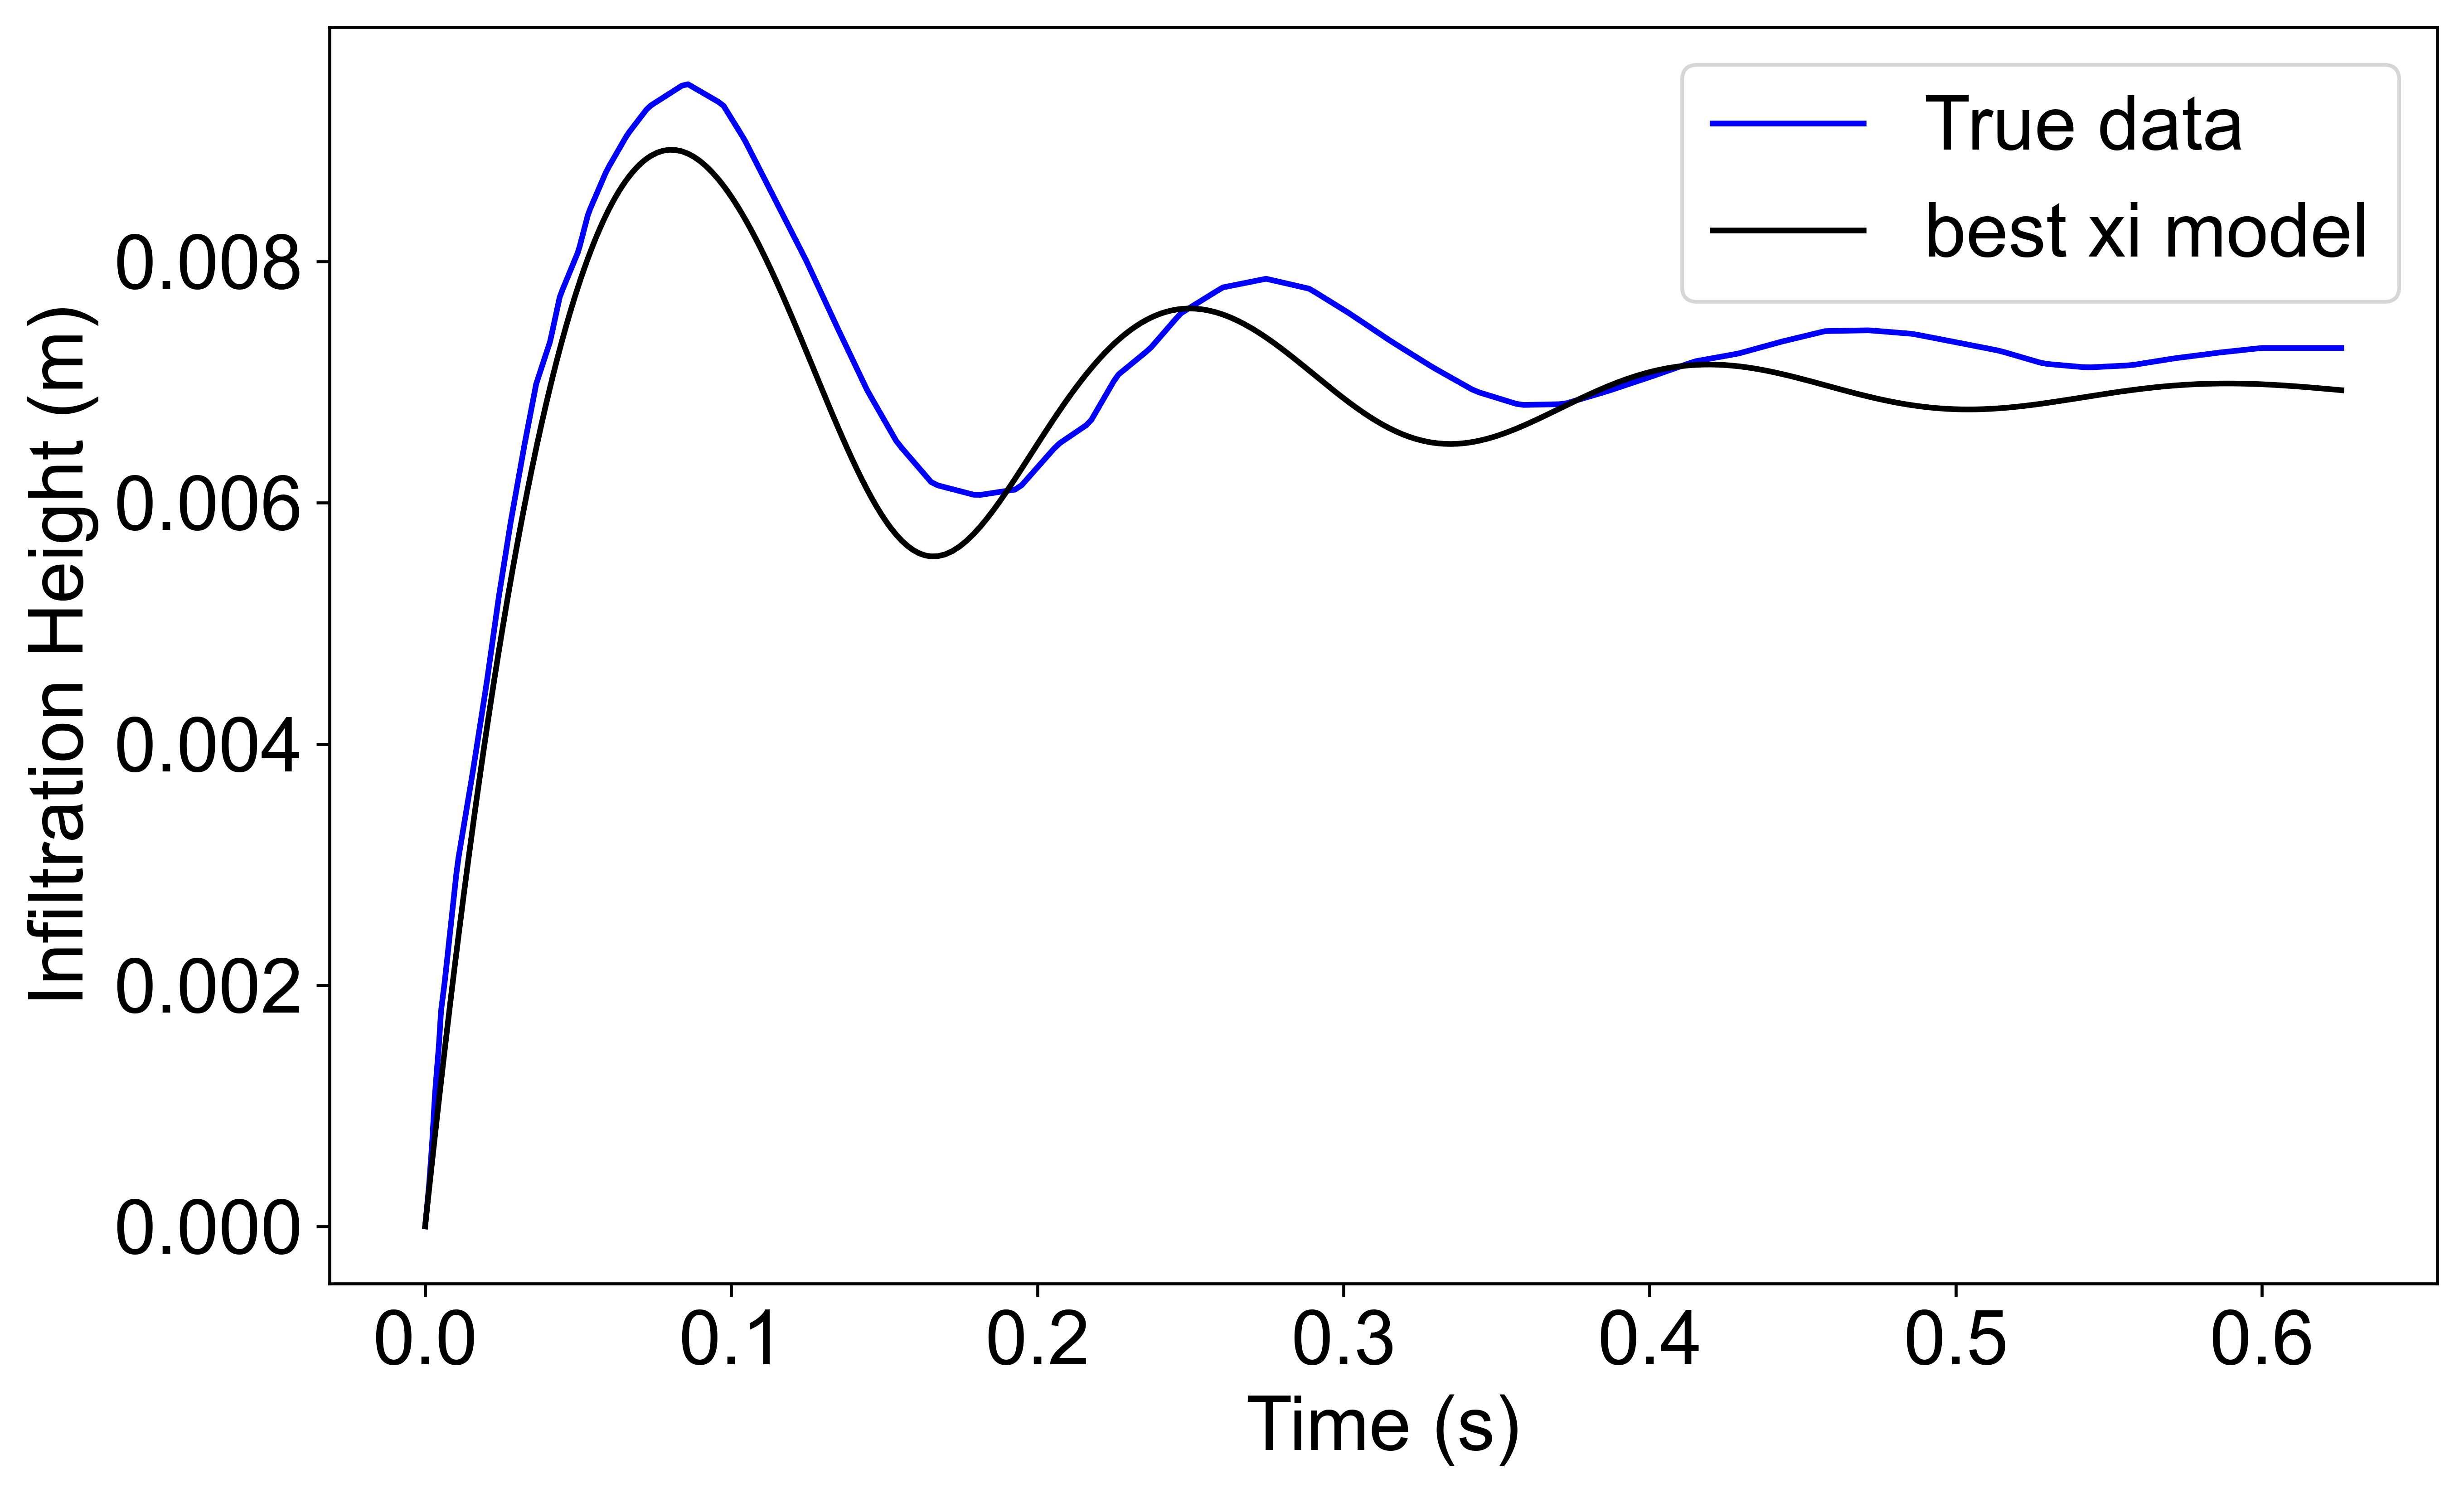

In [9]:
#Simulating Base model without including contact line friction effect
#Initial values and parameters of the digitized data
initial_vals_dgt = np.array([d_height[0], dl_dgt[0]])
digit_params = [density, viscosity, permeability, gravity, capillary_pressure]
simulated_digit = simulate_true_model(digit_params, initial_vals_dgt, d_time)
simulated_L = simulated_digit[0]
simulated_dL = simulated_digit[1]
#print parameter values
print(f"initial values = {initial_vals_dgt}")
print(f"Mean Squared Error = {mean_squared_error(d_height, simulated_L, squared = False)}")

#Simulating extended model with contact line friction effect
#Initial values and parameters of the digitized data
true_friction_coefficient = 78.37
initial_vals_dgt = np.array([d_height[0], dl_dgt[0]])
ext_digit_params = [density, viscosity, permeability, gravity, capillary_pressure, true_friction_coefficient]
ext_simulated_digit = simulate_extended_model(ext_digit_params, initial_vals_dgt, d_time)
ext_simulated_L = ext_simulated_digit[0]
ext_simulated_dL = ext_simulated_digit[1]
#print parameter values
# print(f"extended initial values = {initial_vals_dgt}")
print(f"Extended Mean Squared Error = {mean_squared_error(d_height, ext_simulated_L, squared = False)}")

#Best \xi
best_friction_coefficient = 29.5
best_ext_digit_params = [density, viscosity, permeability, gravity, capillary_pressure, best_friction_coefficient]
bst_simu_L = ext_simulated_digit = simulate_extended_model(best_ext_digit_params, initial_vals_dgt, d_time)[0]
print(f"Extended Mean Squared Error = {mean_squared_error(d_height, bst_simu_L, squared = False)}")

#plot data
plt_figures()
plt.plot(d_time,d_height,'b', label = "True data")
# plt.plot(d_time, simulated_L, 'r-.', label = "base model")
# plt.plot(d_time, ext_simulated_L, 'g--', label = "extended model")
plt.plot(d_time, bst_simu_L, 'k', label = "best xi model")


plt.legend()
# plt.title('Simulation at original viscosity = (0.3 mPa.s)')
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (m)')
plt.show()

In [10]:
radius

0.0006889999999999999

In [11]:
def find_xi(friction_coefficient, Radius = radius):
    xi = (Radius*friction_coefficient)/4
    return xi
find_xi(29.5)

0.005081375

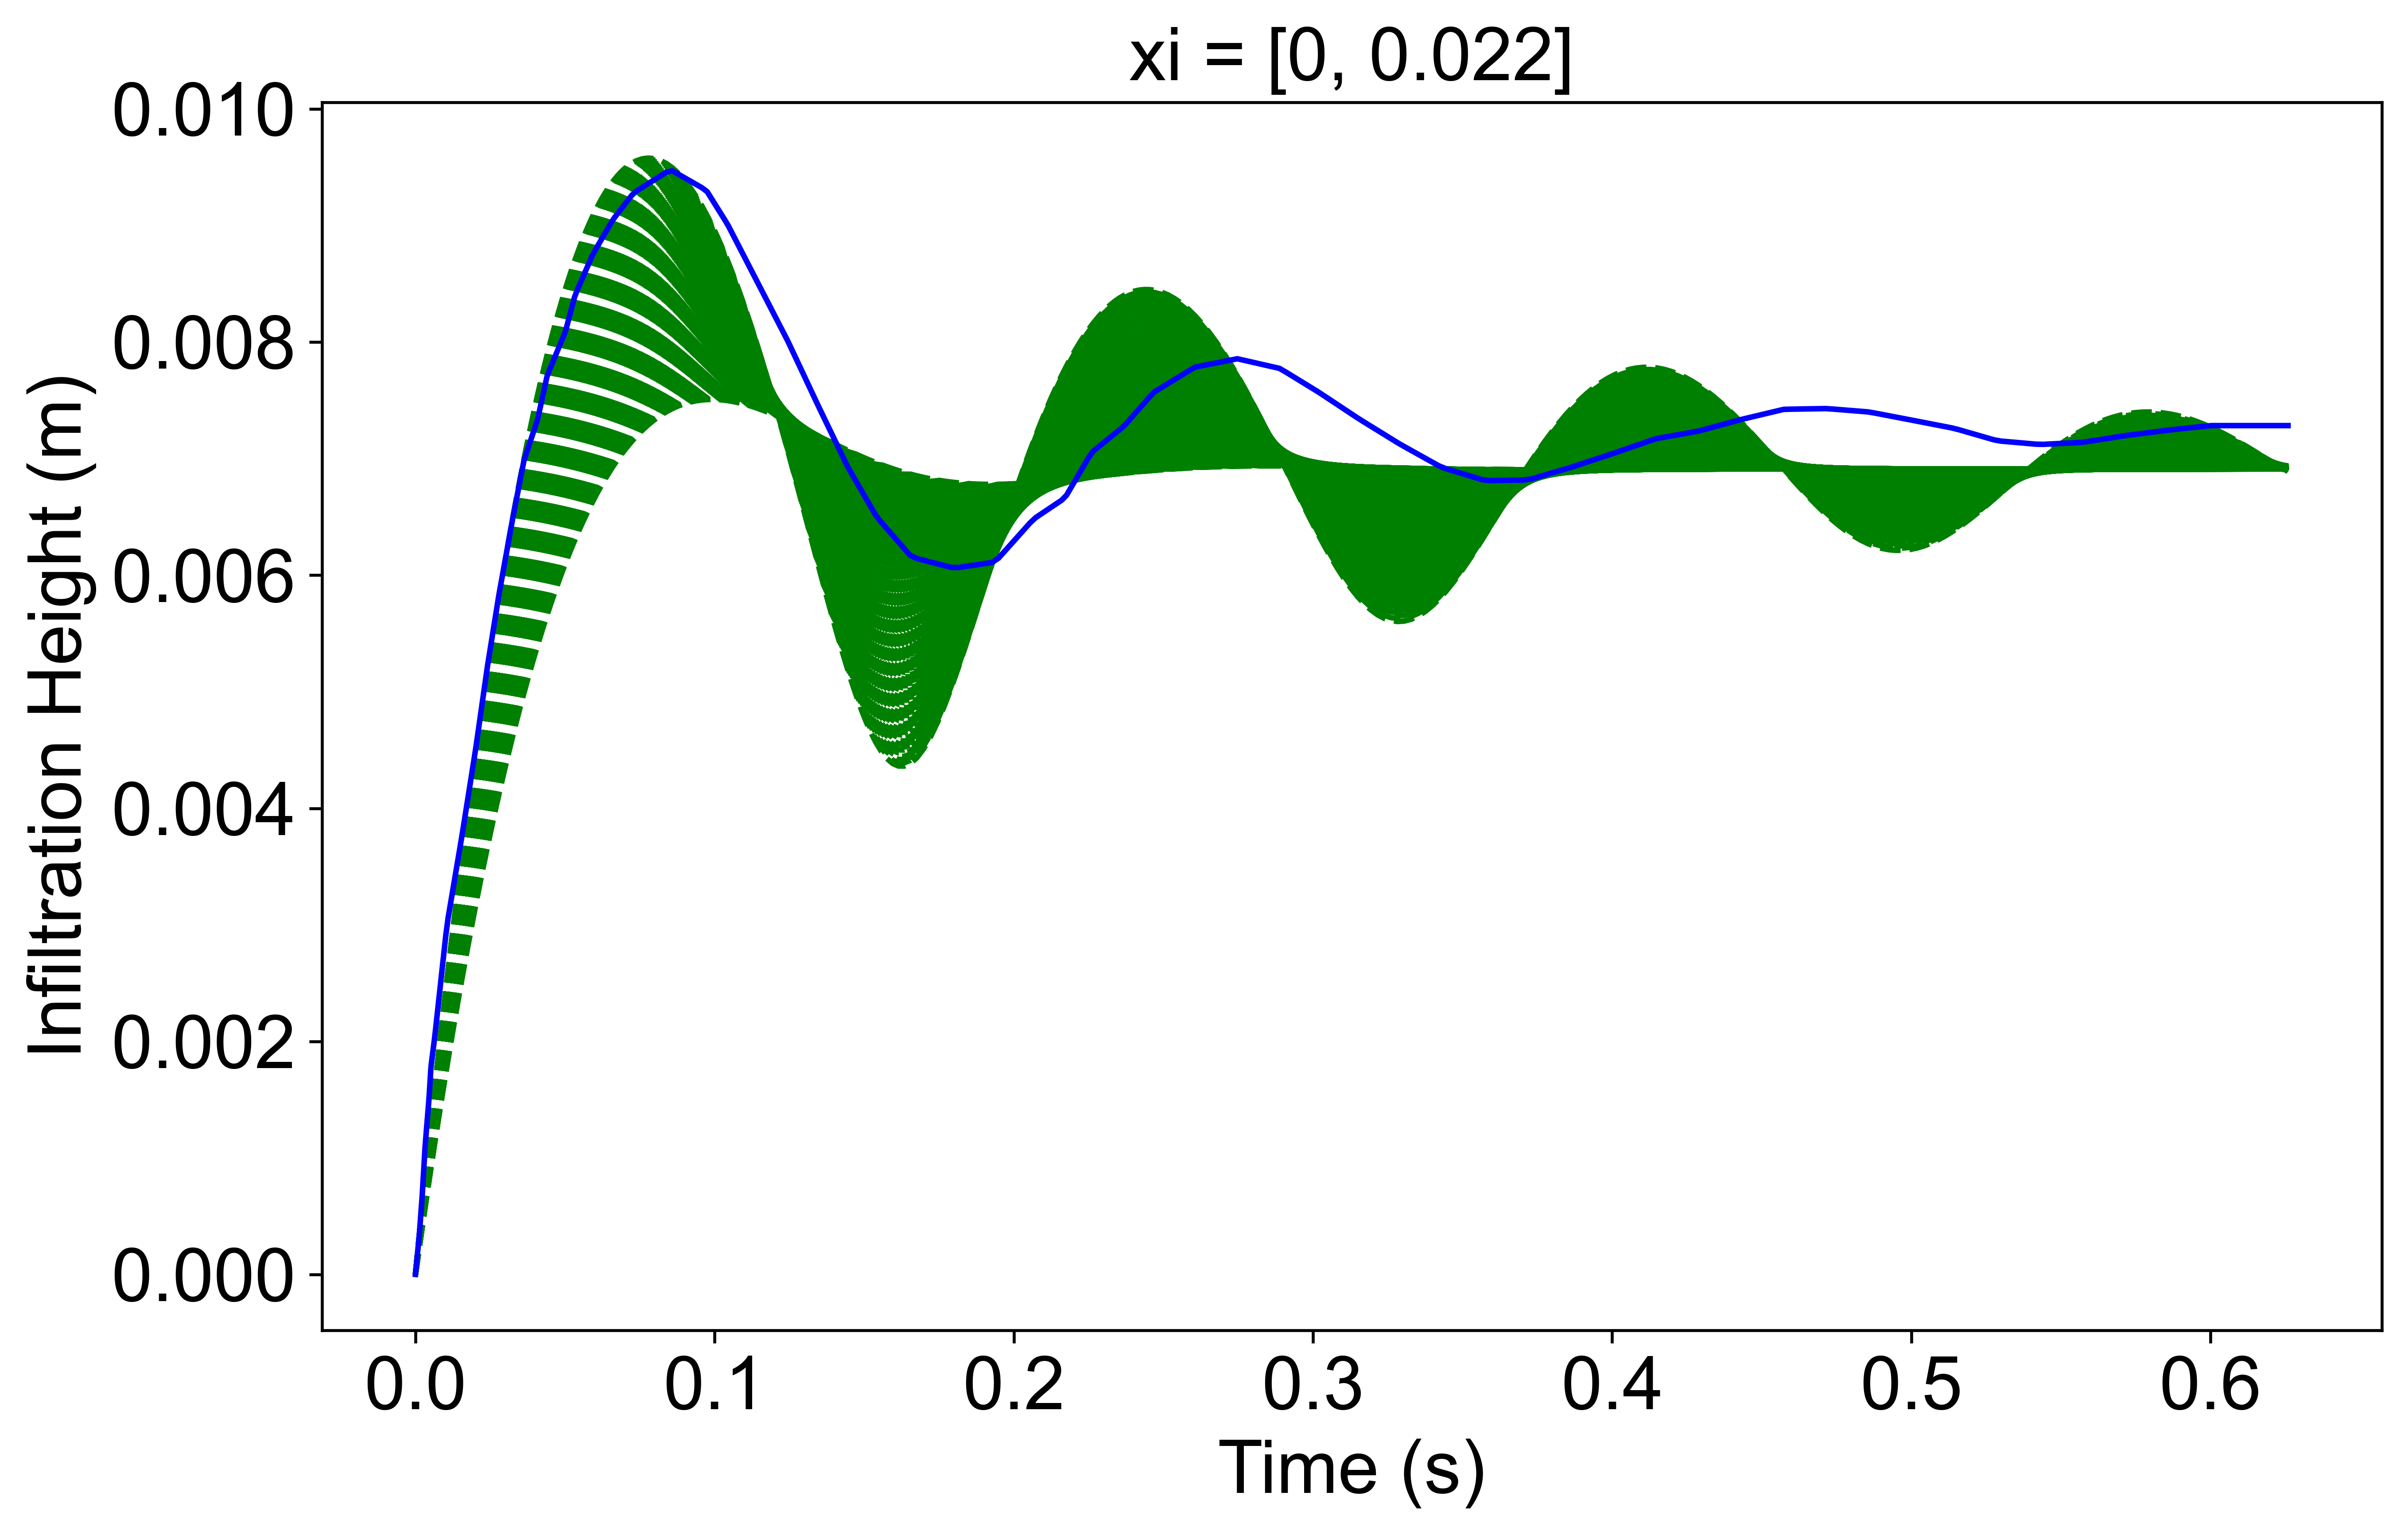

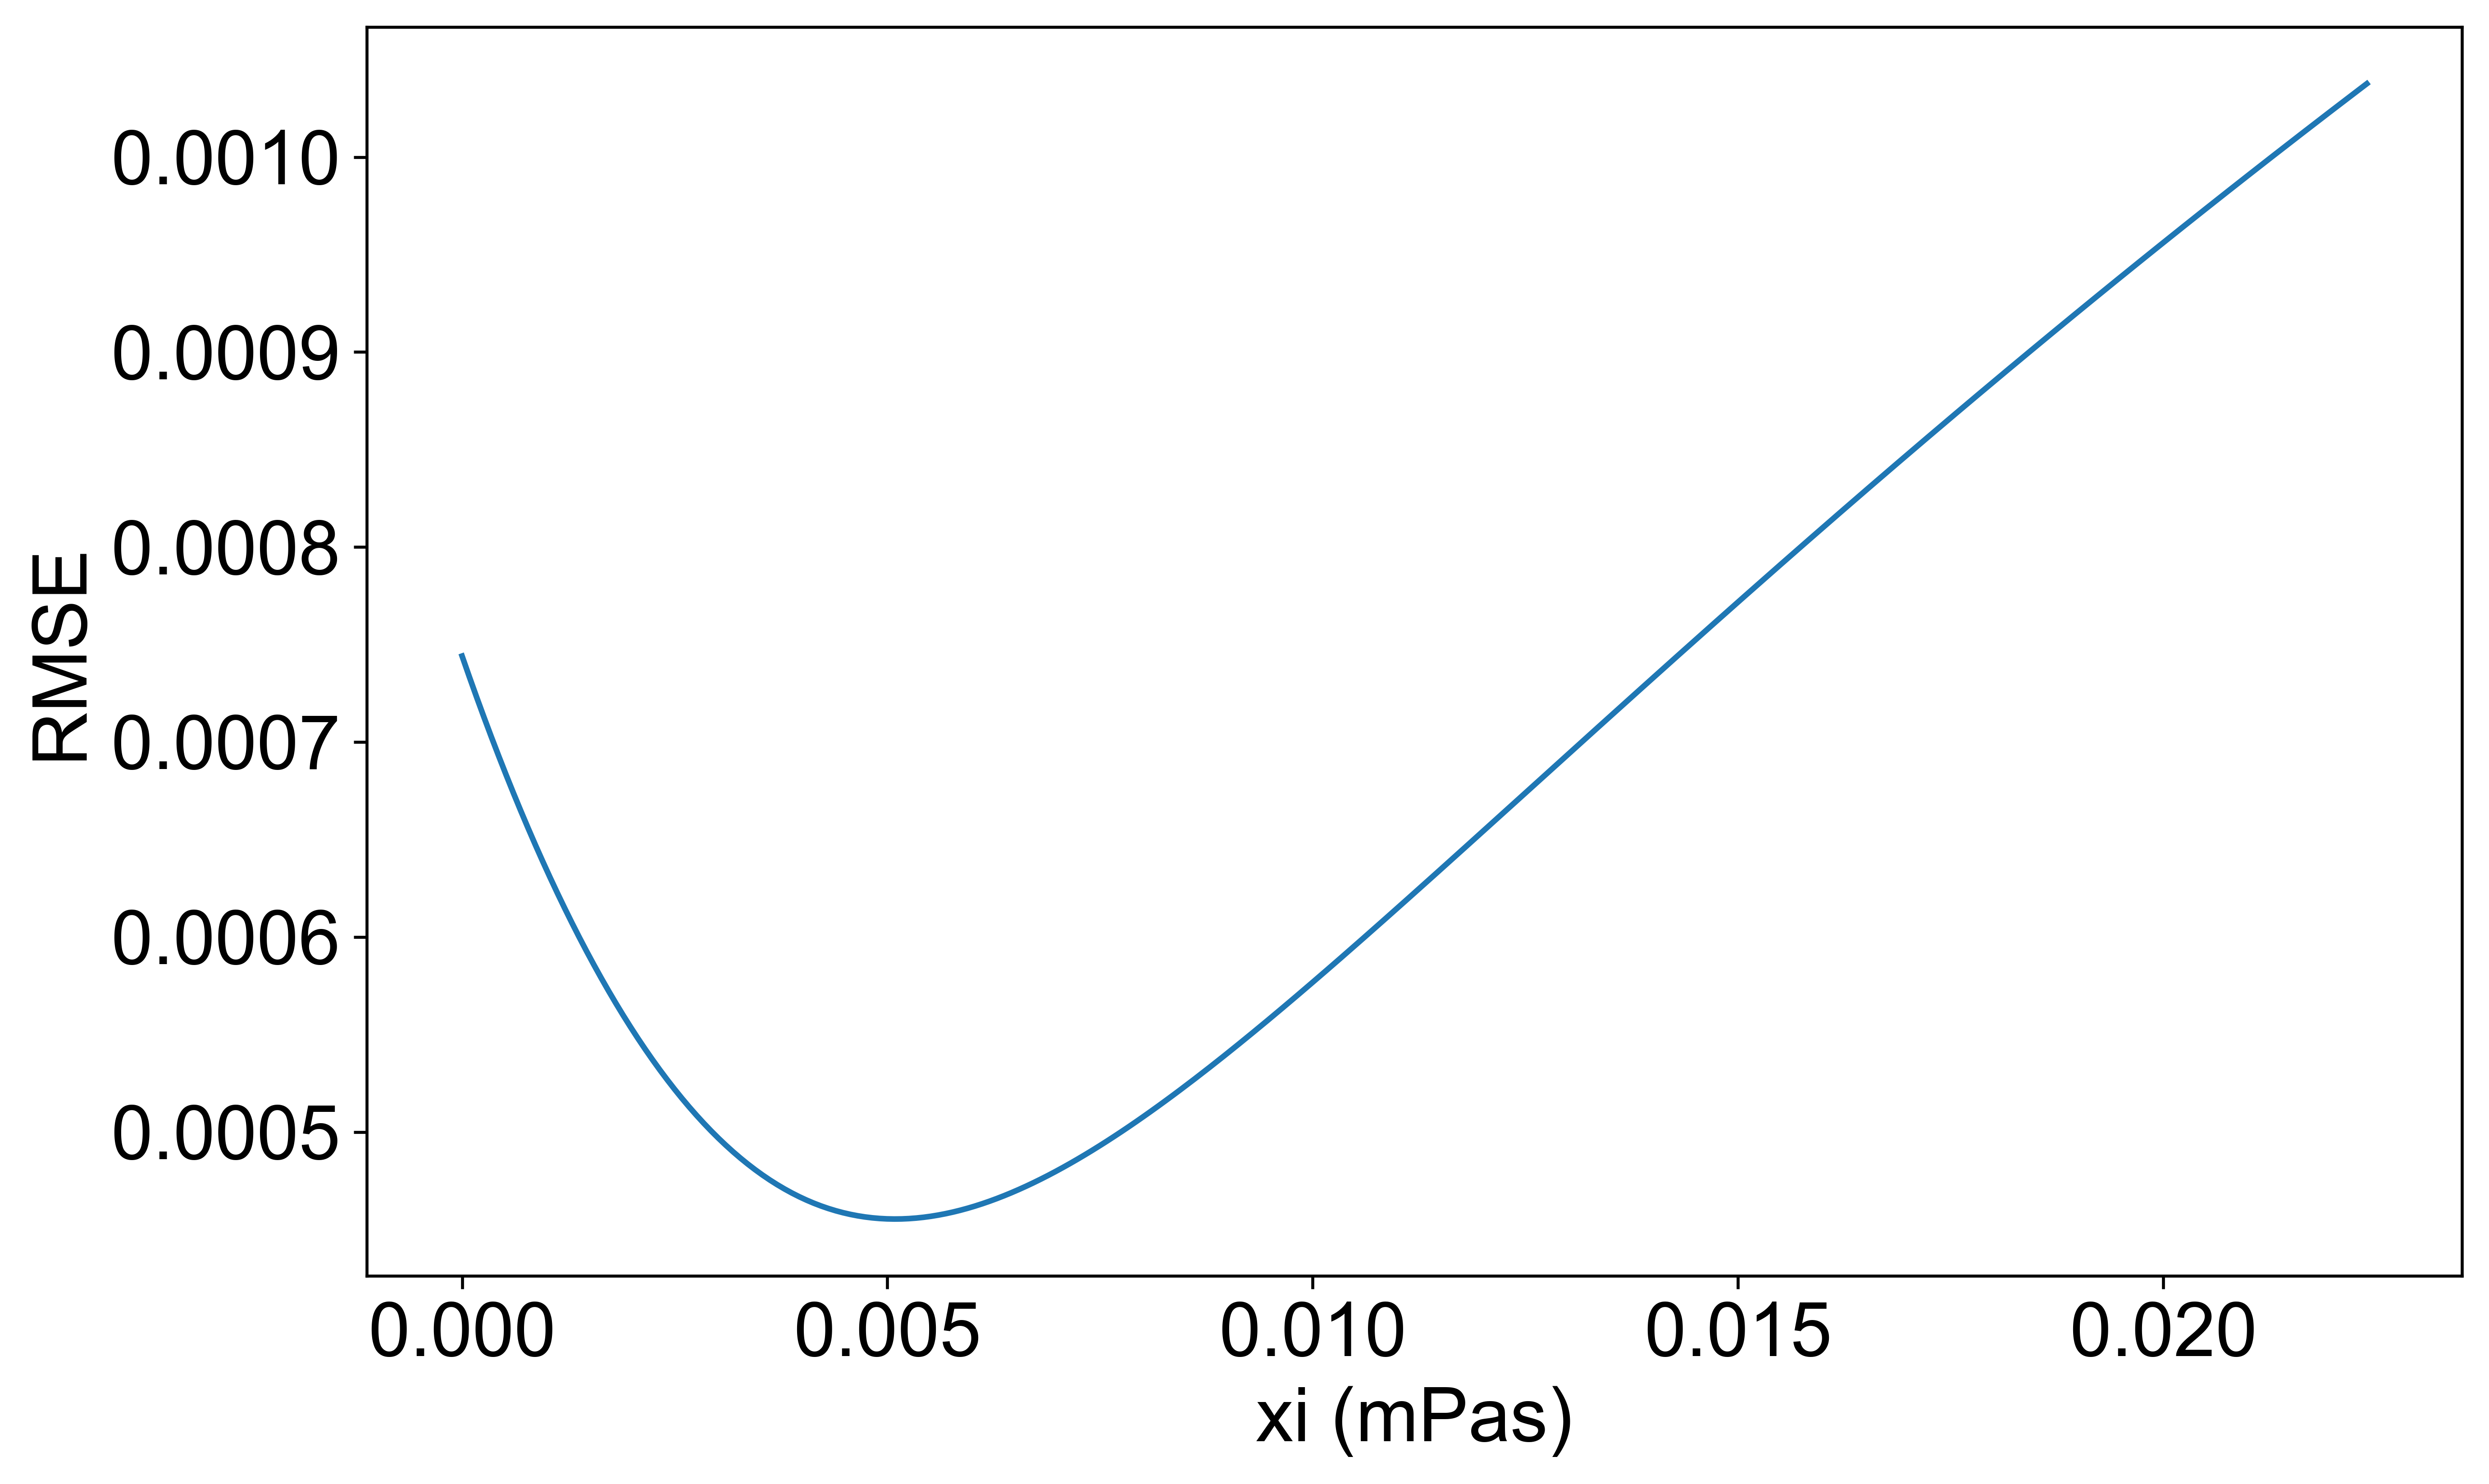

In [12]:
#Simulating extended model with contact line friction effect
#Initial values and parameters of the digitized data
friction_coefficients = np.linspace(0,130,261)
MSE = []
Xi = []
plt_figures()
for friction_coefficient in friction_coefficients:
    initial_vals_dgt = np.array([d_height[0], dl_dgt[0]])
    ext_digit_params = [density, viscosity, permeability, gravity, capillary_pressure, friction_coefficient]
    ext_simulated_digit = simulate_extended_model(ext_digit_params, initial_vals_dgt, d_time)
    ext_simulated_L = ext_simulated_digit[0]
    ext_simulated_dL = ext_simulated_digit[1]
    ext_mse = mean_squared_error(d_height, ext_simulated_L, squared = False)
    MSE.append(ext_mse)
    Xi.append(find_xi(friction_coefficient))
    plt.plot(d_time, ext_simulated_L, 'g--', label = "extended")
    
plt.plot(d_time,d_height,'b', label = "digitized")
# plt.legend()
plt.title('xi = [0, 0.022]')
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (m)')
plt.show()

plt_figures()
plt.plot(Xi,MSE)
plt.xlabel('xi (mPas)')
plt.ylabel('RMSE')
plt.show()

In [13]:
MSE = np.array(MSE)
Xi[np.argmin(MSE)], Xi[-1]

(0.005081375, 0.0223925)

# Normal Sindy Learning

In [14]:
def SINDY_(noisy_data,t, threshold = 0.03, wl = 15, condit = False):
    """Fits SINDy model to a data and returns the resulting coefficients"""
    Poly_lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=True)
    optimizer = ps.STLSQ(threshold)#threshold = 0.3)
    smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': wl})
#     dldt = smoothed_fd(noisy_data,t)
#     L_dl = np.vstack((noisy_data,dldt)).T

    model = ps.SINDy(
        differentiation_method=smoothed_fd,
        feature_library=Poly_lib,
        optimizer=optimizer,
        feature_names=["l", "v"] 
    )
    if condit: 
        model.fit(noisy_data, t)
        model.print()
        model.get_feature_names()
        return model.coefficients()#.reshape(-1)
    
    else:
        model.fit(noisy_data, t)
        return model

(l)' = 1.000 v
(v)' = -195.995 1 + 47438.337 l + 1278.769 v + -2780356.083 l^2 + -163964.739 l v + -1919.094 v^2
Mean Squared Error = 0.0022845004865087886
Extended Mean Squared Error = 0.00046046961547835754


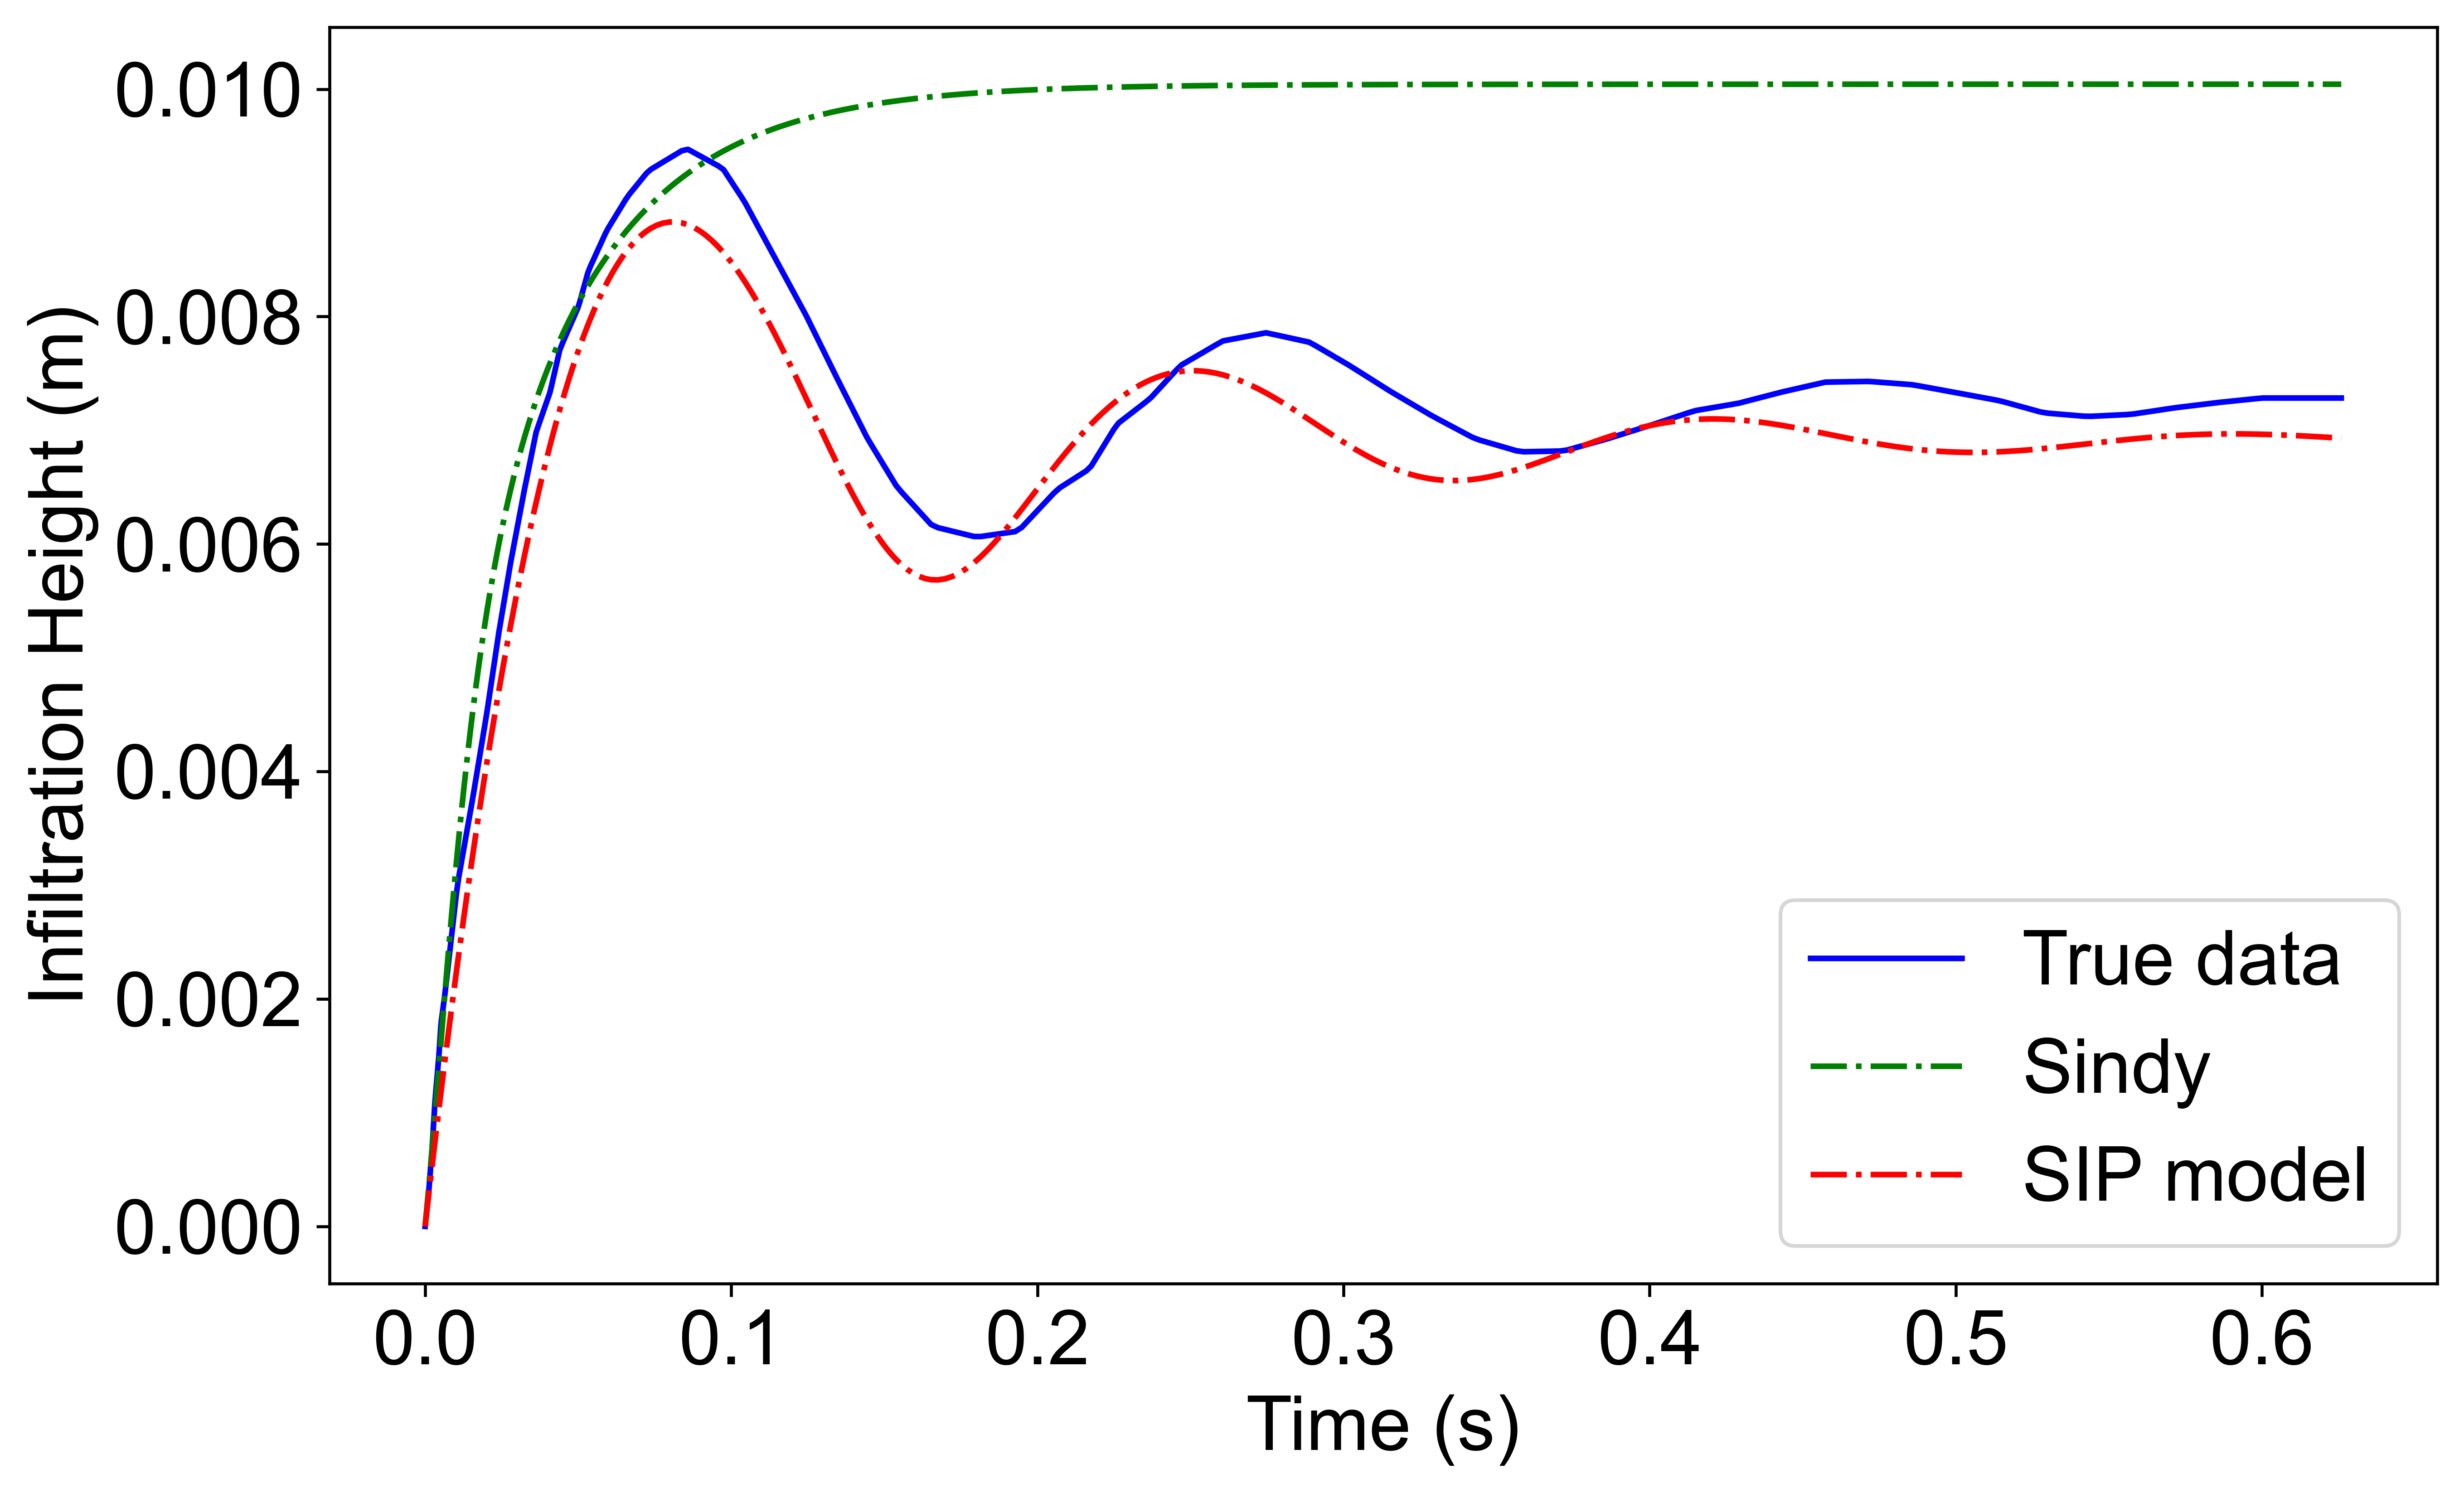

In [15]:
# differentiate data to get dl/dt, d2l/dt2 and d3l/dt3
wdl = 15

dl_dgt,d2l_dgt, _ = differentiate(d_height, d_time, wdl)

#sindy_data
dgt_sindy_data = np.vstack((x_dgt, dl_dgt)).T

sdmodel = SINDY_(dgt_sindy_data, d_time, 0.03, wl = wdl)
sdmodel.print()
sdmodel.coefficients()
sindy_sim = sdmodel.simulate(initial_vals_dgt, d_time)

print(f"Mean Squared Error = {mean_squared_error(d_height, sindy_sim[:,0], squared = False)}")

#SIP model \xi
best_friction_coefficient = 34.27
best_ext_digit_params = [density, viscosity, permeability, gravity, capillary_pressure, best_friction_coefficient]
bst_simu_L = ext_simulated_digit = simulate_extended_model(best_ext_digit_params, initial_vals_dgt, d_time)[0]
print(f"Extended Mean Squared Error = {mean_squared_error(d_height, bst_simu_L, squared = False)}")


plt_figures()
plt.plot(d_time, d_height, 'b', label = "True data")
plt.plot(d_time, sindy_sim[:,0], 'g-.', label = 'Sindy')
plt.plot(d_time, bst_simu_L, 'r-.', label = "SIP model")
plt.legend()
# plt.title('Simulation at original viscosity = (0.3 mPa.s)')
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (m)')
plt.show()

# SIP Model

In [16]:
# Helper Functions
def sample_and_extrapolate(array, time_array, num_samples):
    # Remove first and last row of the array and the corresponding time
    f_arr,l_arr = array[0],array[-1]
    f_time,l_time = time_array[0], time_array[-1]
    
    array_,time_array_ = np.copy(array),np.copy(time_array)
    
    array = array[1:-1]
    time_array = time_array[1:-1]
    
    # Randomly sample from the remaining array based on num_samples
    sampled_indices = sort_matrix(np.random.choice(len(array), size=num_samples, replace=False)).reshape(-1)
    sampled_array = array[sampled_indices]
    sampled_time = time_array[sampled_indices]
    
    # Add previously removed first and last row back to the array
    sampled_array = np.concatenate(([f_arr], sampled_array, [l_arr]))
    sampled_time = np.concatenate(([f_time], sampled_time, [l_time]))
    
    
    # Extrapolate for all time in the time array
    interpolated_array = np.interp(time_array_, sampled_time , sampled_array)
    return interpolated_array

def sort_matrix(matrix, col_idx = -1):
    """Sorts a matrix by a predifine column in ascending order"""
    if len(matrix.shape)  == 1:
        matrix= matrix.reshape(-1,1)
    # Sort the matrix by the specified column
    sorted_matrix = sorted(matrix, key=lambda x: x[col_idx])
    return np.array(sorted_matrix)


def split_matrix(matrix):
    """Splits the last column of a matrix from the original matrix and returns the new matrix and the column"""
    matrix = matrix.tolist()
    # Split the last column from the matrix
    last_column = [row.pop() for row in matrix]
    return np.array(matrix),np.array(last_column)

def min_idx(arr1,arr2):
    """Finds the minimum of arr2 and return the corresponding arr1 values with it """
#     arr2 = arr2.tolist()
    min_value = min(arr2)
    min_index = arr2.index(min_value)
    return ([arr1[min_index],min_value])

# x_xtrap = sample_and_extrapolate(x,t,int(0.8*len(x)))

# STLSQ function for model learning
def Learn_Model(X,y, thresh=0.01):
    sindy_model = SequentialThresholdLeastSquares(threshold=thresh, fit_intcpt = False)
    params = sindy_model.fit(X,y).reshape(-1)
    return params

In [17]:
# Function Library 
def Library(obs_height, obs_time, wl=wdl, basic= False):
    #differentiate data
    dl,d2l,d3l = differentiate(obs_height, obs_time, wl) 
    
    ones = np.ones(len(obs_height))
    l = obs_height 
    lsq = l**2
    ldl = l*dl    
    ldsql = l*d2l
    dlsq = dl**2
    Lib1 = np.vstack((l, ldl, dlsq,  ldsql, lsq, dl)).T # Stack data to get matrix
    Lib2 = np.vstack((l, ldl, dlsq,  ldsql)).T # Basic library containing only necessary terms
    if basic:
        return Lib2
    else: 
        return Lib1
    
# (alpha*l + beta*l*v + delta*v**2 + mu*l**2 - Pc)

In [18]:
# Defining intervals
alpha = [600, 800]
beta = [600, 800]
Gamma = [6800, 7800]
delta = [5000, 5800]
nu = [0, 50]
mu = [0,10]

# Learning Best Contact Angle

In [19]:
def simulate_theta(theta = [0, 6965.1]):
    from scipy.integrate import odeint
    density,viscosity,permeability,gravity, capillary_pressure = [710, 0.0003, 5.934012499999999e-08, 9.81, 49.45221]
    angle, alpha = theta
    capillary_pressure =  get_PC(surface_tension, angle, radius)     
    Pc = capillary_pressure
    #capillary_pressure*(1/(np.cos(angle*0.5*np.pi/90)))
    
    initial_vals = initial_vals_dgt
    simu_time = d_time
    
#     alpha = density*gravity
    beta  = viscosity/permeability
    gamma = density
    delta = density
    
    def infiltration_model(t, S):
        l, v = S
        dv =  (-1/(gamma*l)) * (alpha*l + beta*l*v + delta*v**2 - Pc)
        return [v,dv]
    
    Simulated = odeint(infiltration_model, y0=initial_vals, t= simu_time,  tfirst = True).T
    return Simulated[0] 

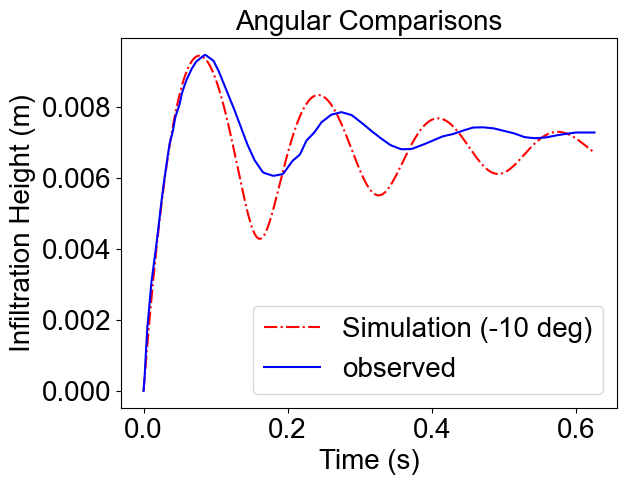

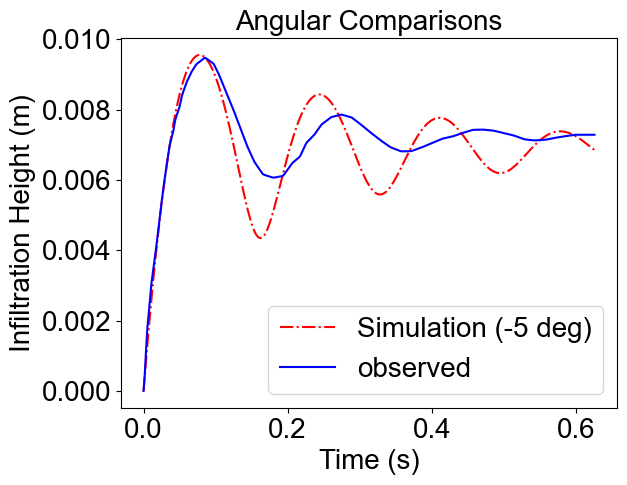

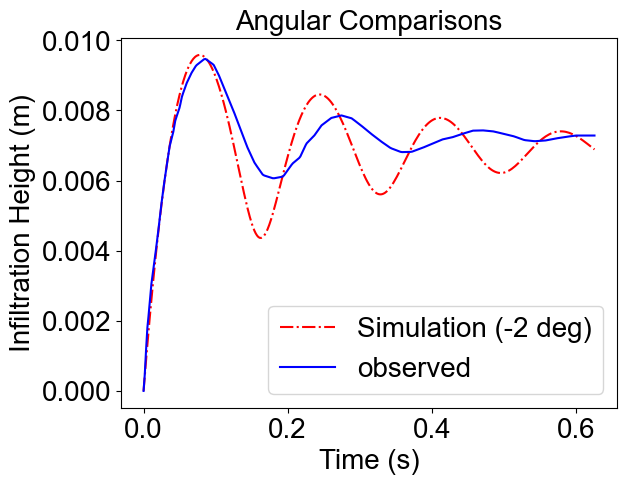

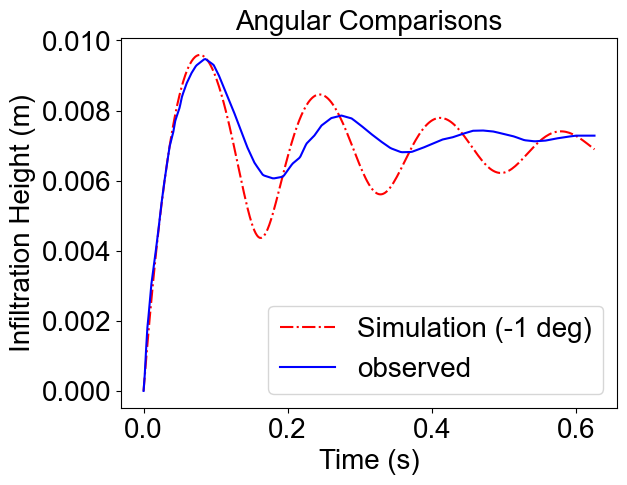

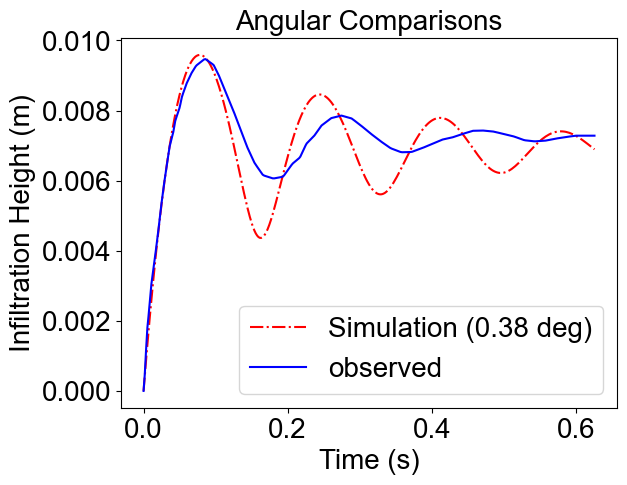

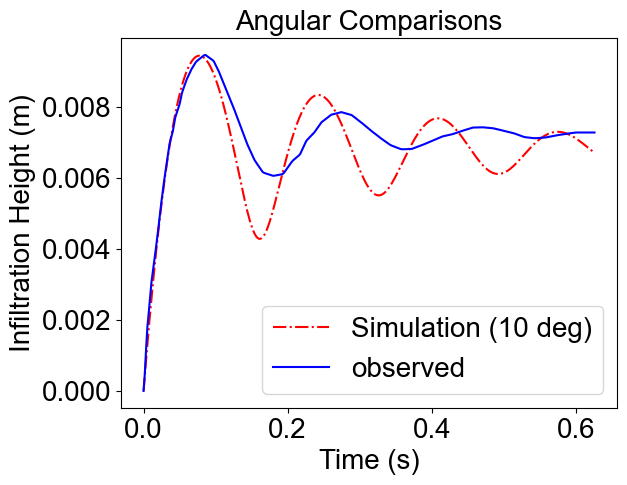

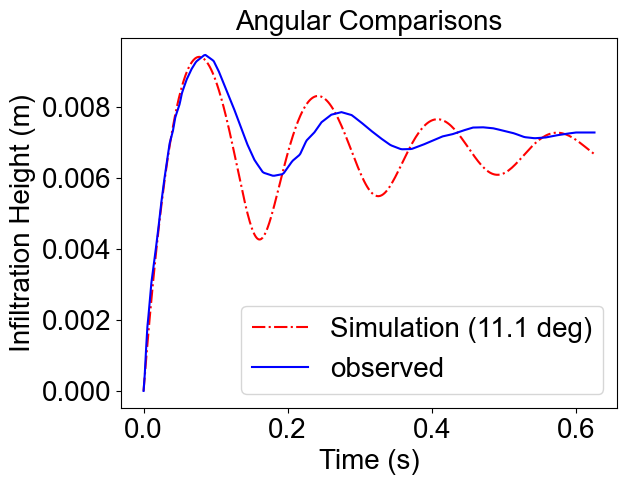

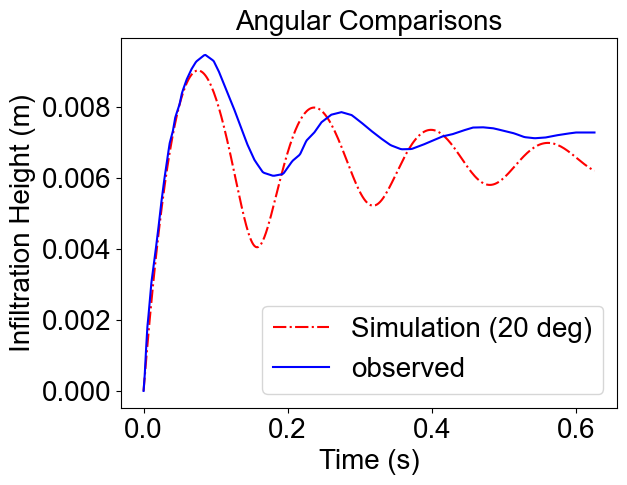

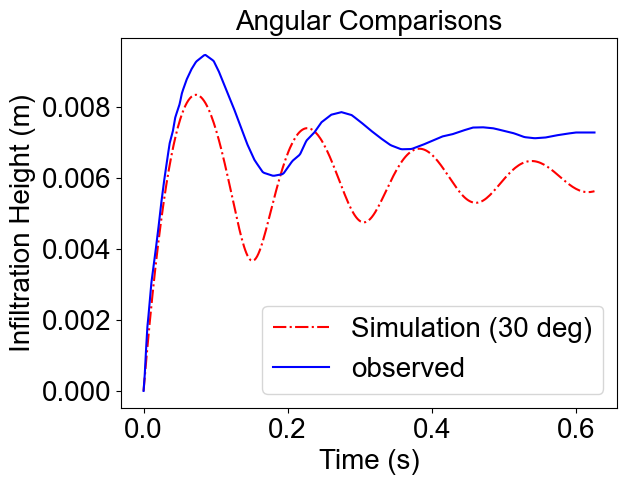

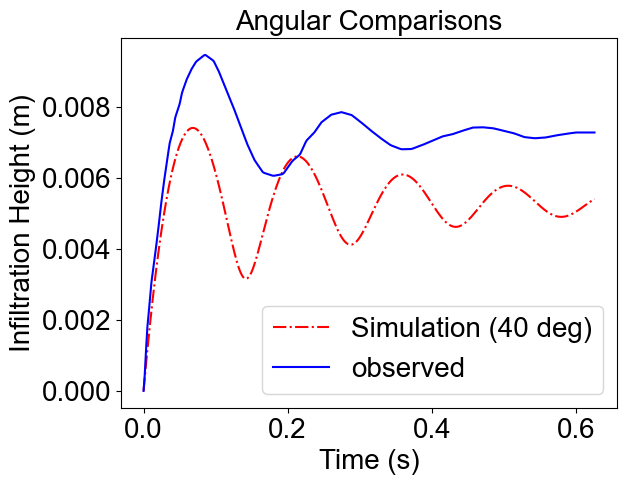

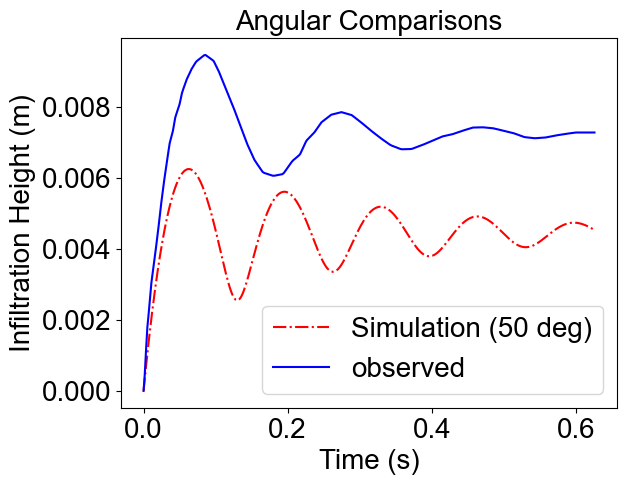

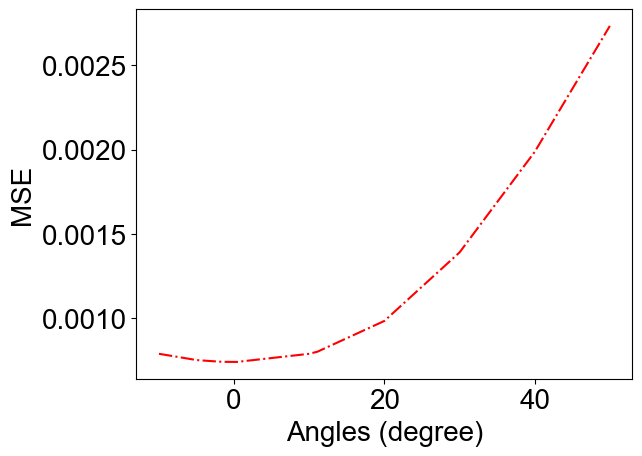

In [20]:
angles = [-10, -5, -2, -1, 0.38, 10, 11.1, 20, 30, 40, 50]
angle_labels = ['-10', '-5', '-2', '-1', '0.38', '10', '11.1', '20', '30', '40', '50']
mse = []

for idx in range(len(angles)):
    sim_tmp = simulate_theta([angles[idx], 6965.1])
    plt.plot(d_time, sim_tmp , 'r-.', label = f"Simulation ({angle_labels[idx]} deg)")
    plt.plot(d_time, d_height,'b', label = "observed")

    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Infiltration Height (m)')
    plt.title("Angular Comparisons")
    plt.show()

    mse.append(mean_squared_error(d_height, sim_tmp, squared = False))

plt.plot(angles, mse, 'r-.')
plt.xlabel(f"Angles (degree)")
plt.ylabel(f"MSE")
plt.show()

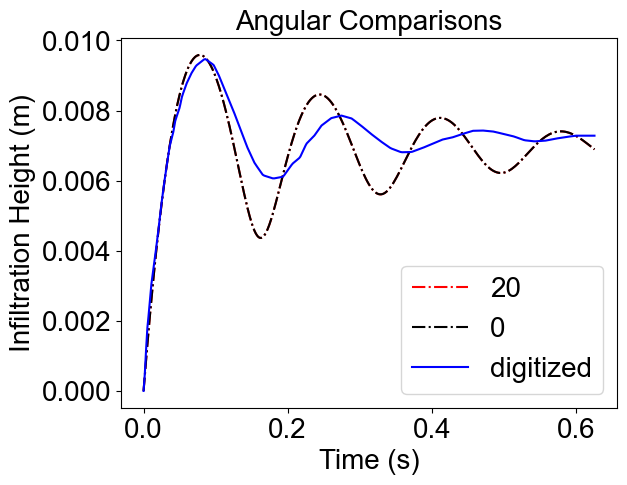

In [21]:

# plt.plot(d_time,simulate_theta([11.1, 6965.1]), 'r-.', label = "11.1")
plt.plot(d_time,simulate_theta([-1, 6965.1]), 'r-.', label = "20")
plt.plot(d_time,simulate_theta([0, 6965.1]), 'k-.', label = "0")
# plt.plot(d_time,simulate_theta([7.58, 6965.1]), 'g-.', label = "7.58")
# plt.plot(d_time,simulate_theta([  29.21572407, 7543.60492497]), 'g-.', label = "7.58")
plt.plot(d_time,d_height,'b', label = "digitized")

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Infiltration Height (m)')
plt.title("Angular Comparisons")
plt.show()

# mean_squared_error(d_height, simulate_theta([  29.21572407, 7543.60492497]), squared = False)

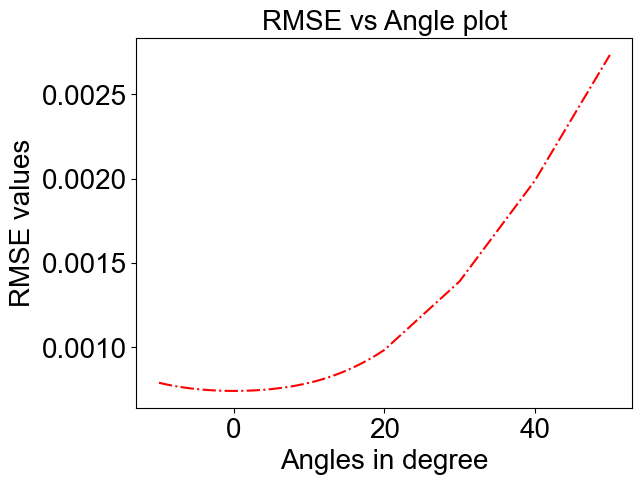

In [22]:
angles = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 10, 11.1, 20, 30, 40, 50]

thetas = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1,
          0,1,2,3,4,5, 6.53,7.53, 7.58, 7.8, 8.0, 9.0, 10.5,11.0, 11.1,11.2,
          11.3, 11.4, 11.5, 11.7, 12, 13,14, 15, 16, 17, 18, 19, 20,30, 40, 50]
mse_vals =[]
for theta in thetas:
    simulated = simulate_theta([theta,6965.1])
    mse = mean_squared_error(d_height, simulated, squared = False)
    mse_vals.append(mse)
#     print(f"MSE value for {theta} : {mse}")
    
plt.plot(thetas,mse_vals, 'r-.')
plt.xlabel("Angles in degree")
plt.ylabel("RMSE values")
plt.title("RMSE vs Angle plot")
plt.show()

C:\Users\USER\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


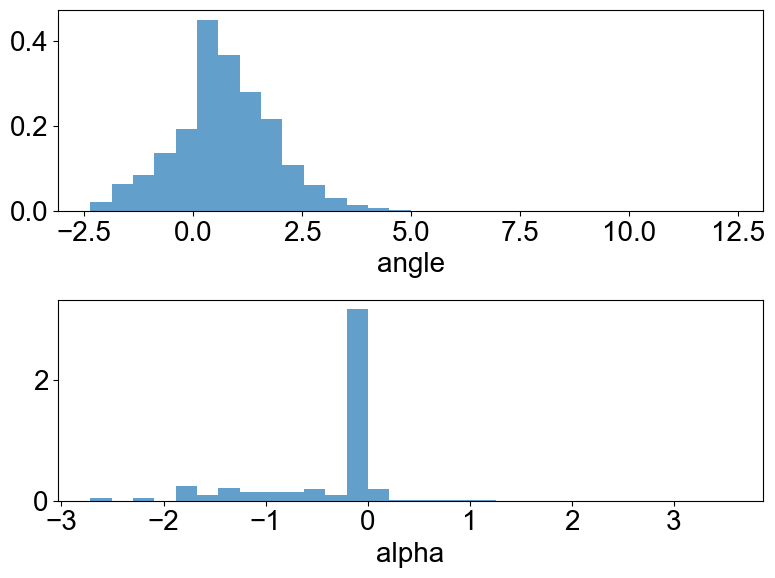

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

Y = d_height
X=1
# Define the log-likelihood function
def log_likelihood(theta, x, y):
#     sigma = 0.1
    angle, sigma = theta
    model = simulate_theta([angle,6965.1])
    residual = y - model
    log_like = -0.5 * np.sum(residual**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return log_like

# Define the log-prior function
def log_prior(theta):
    angle, sigma = theta
    if 0 <= angle < 90 and 0 < sigma < 10:
        return 0.0
    return -np.inf

# Define the log-posterior function
def log_posterior(theta, x, y):
    log_prior_val = log_prior(theta)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(theta, x, y)

# Set up the sampler
ndim = 2  # Number of parameters (angle, alpha)
nwalkers = 100  # Number of walkers
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(X, Y))

# Set initial positions for the walkers
p0 = np.random.randn(nwalkers, ndim)

# Run the sampler
nsteps = 1000  # Number of steps
sampler.run_mcmc(p0, nsteps)

# Get the posterior samples
samples = sampler.get_chain(flat=True)

# Plot the posterior distributions
labels = ['angle', 'alpha','sigma']
plt.figure(figsize=(8, 6))
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.hist(samples[:, i], bins=30, density=True, alpha=0.7)
    plt.xlabel(labels[i])
plt.tight_layout()
plt.show()

In [24]:
from scipy import stats as st
np.mean(samples,0)

array([ 0.7339876 , -0.33711277])

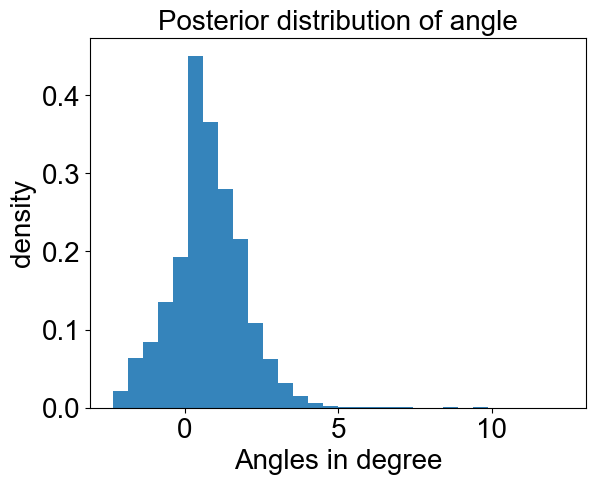

In [25]:
plt.hist(samples[:, 0], bins=30, density=True, alpha=0.9)[-1]
plt.xlabel("Angles in degree")
plt.ylabel("density")
plt.title("Posterior distribution of angle")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_23260\318591344.py:23: RuntimeWarning: invalid value encountered in log
  sigma_prior = -np.log(sigma)  # Inverse-Gamma(0.001, 0.001)


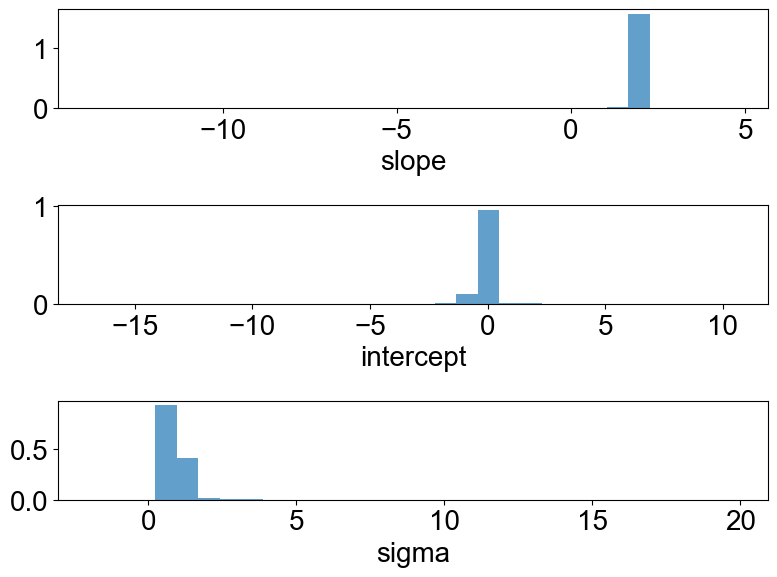

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

# Generate some sample data
np.random.seed(42)
X = np.linspace(0, 10, 100)
Y = 2 * X + np.random.normal(0, 1, 100)

# Define the log-likelihood function
def log_likelihood(theta, x, y):
    slope, intercept, sigma = theta
    model = slope * x + intercept
    residual = y - model
    log_like = -0.5 * np.sum(residual**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return log_like

# Define the log-prior function
def log_prior(theta):
    slope, intercept, sigma = theta
    slope_prior = -0.5 * ((slope - 0) / 2)**2  # N(0, 2)
    intercept_prior = -0.5 * ((intercept - 0) / 2)**2  # N(0, 2)
    sigma_prior = -np.log(sigma)  # Inverse-Gamma(0.001, 0.001)
    return slope_prior + intercept_prior + sigma_prior

# Define the log-posterior function
def log_posterior(theta, x, y):
    log_prior_val = log_prior(theta)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(theta, x, y)

# Set up the sampler
ndim = 3  # Number of parameters (slope, intercept, sigma)
nwalkers = 100  # Number of walkers
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(X, Y))

# Set initial positions for the walkers
p0 = np.random.randn(nwalkers, ndim)

# Run the sampler
nsteps = 1000  # Number of steps
sampler.run_mcmc(p0, nsteps)

# Get the posterior samples
samples = sampler.get_chain(flat=True)

# Plot the posterior distributions
labels = ['slope', 'intercept', 'sigma']
plt.figure(figsize=(8, 6))
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.hist(samples[:, i], bins=30, density=True, alpha=0.7)
    plt.xlabel(labels[i])
plt.tight_layout()
plt.show()

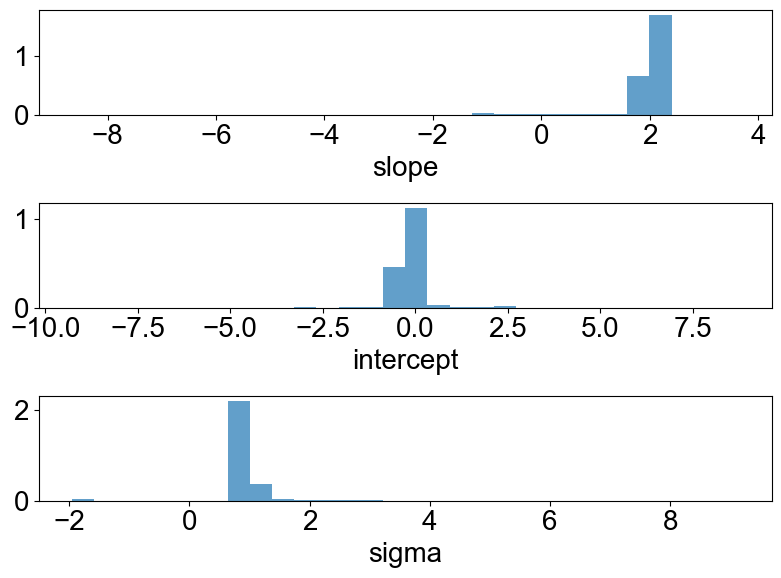

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

# Generate some sample data
np.random.seed(42)
X = np.linspace(0, 10, 100)
Y = 2 * X + np.random.normal(0, 1, 100)

# Define the log-likelihood function
def log_likelihood(theta, x, y):
    slope, intercept, sigma = theta
    model = slope * x + intercept
    residual = y - model
    log_like = -0.5 * np.sum(residual**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return log_like

# Define the log-prior function
def log_prior(theta):
    slope, intercept, sigma = theta
    if -10 < slope < 10 and -10 < intercept < 10 and 0 < sigma < 10:
        return 0.0
    return -np.inf

# Define the log-posterior function
def log_posterior(theta, x, y):
    log_prior_val = log_prior(theta)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(theta, x, y)

# Set up the sampler
ndim = 3  # Number of parameters (slope, intercept, sigma)
nwalkers = 100  # Number of walkers
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(X, Y))

# Set initial positions for the walkers
p0 = np.random.randn(nwalkers, ndim)

# Run the sampler
nsteps = 1000  # Number of steps
sampler.run_mcmc(p0, nsteps)

# Get the posterior samples
samples = sampler.get_chain(flat=True)

# Plot the posterior distributions
labels = ['slope', 'intercept', 'sigma']
plt.figure(figsize=(8, 6))
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.hist(samples[:, i], bins=30, density=True, alpha=0.7)
    plt.xlabel(labels[i])
plt.tight_layout()
plt.show()


In [28]:
np.mean(samples,0)

array([ 1.93671221, -0.13488546,  0.94865941])